# ML methods for Hand gesture recognition using HaGRID dataset

## Import neccessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import math
from tqdm import tqdm
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from glob import glob

In [2]:
!pip install --upgrade Pillow 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.


In [3]:
!pip install xgboost

## Read annotation files

In [4]:
annotation_dir = '/kaggle/input/hagrid-sample-500k-384p/hagrid-sample-500k-384p/ann_train_val'
annotation_paths = glob(os.path.join(annotation_dir, "*.json"))
cls_dataframes = (pd.read_json(f).transpose() for f in annotation_paths)
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

In [5]:
annotation_df.head()

,bboxes,labels,leading_hand,leading_conf,user_id
000dfde3-a3a2-41b3-a3eb-e52744bf3ac4,"[[0.21083398, 0.26728873000000003, 0.21714227,...","[ok, no_gesture]",right,1.0,1bcd0375d49fff4bf0b03f15f17d2e770ba1012a80828b...
001b114a-d181-44bd-af8c-a883f1cc482e,"[[0.34819273, 0.25233828, 0.16835899000000001,...","[ok, no_gesture]",right,1.0,643a9e40127b25af28538c5c820aaeb5e2b679c8dd6312...
00335b2b-5dc2-4910-abbe-504f85f799e8,"[[0.26782306, 0.74153527, 0.05330742, 0.070987...","[no_gesture, ok]",left,1.0,fccdaa5e75cf5a740da1d3289707020a4033d67a05f7ac...
004fac40-47b8-4b32-b8a4-cb29c8d0946f,"[[0.13206638, 0.47038446, 0.12575317, 0.141712...","[ok, no_gesture]",right,1.0,e705025ad2e72d332adcbe2a332704ea47b17c2d18c0f0...
0064f9a1-322a-4530-a1bf-2440bcdd2dc0,"[[0.32705077, 0.46410392, 0.10081124, 0.070292...","[ok, no_gesture]",right,1.0,809871aa94f9f055e1ec0a3e93dc74ba2ceef00729a494...


In [6]:
def get_hand_bounding_box(image_name, label, annotation_df):
    annotation = annotation_df.loc[image_name]
    if len(annotation['labels']) > 1:
        idx = annotation['labels'].index(label)
        idx2 = annotation['labels'].index('no_gesture')
        bboxes = annotation['bboxes'][idx]
        bboxes2 = annotation['bboxes'][idx2]
        return bboxes, bboxes2
    else:
        bboxes = annotation['bboxes'][0]
        return [bboxes]
   

(384, 512)


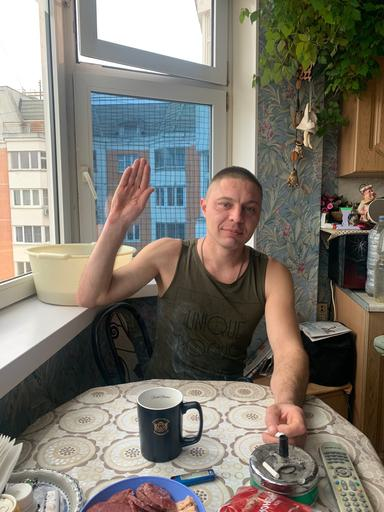

In [17]:
from PIL import ImageDraw
import PIL
img = PIL.Image.open('/kaggle/input/hagrid-sample-500k-384p/hagrid-sample-500k-384p/hagrid_500k/train_val_stop/73aebbd6-8385-4522-a1cb-049b512516ec.jpg').convert('RGB')

width, height = img.size
annotated_img = img.copy()
draw = ImageDraw.Draw(annotated_img)
fnt_size = 25


bboxes = get_hand_bounding_box('73aebbd6-8385-4522-a1cb-049b512516ec', 'stop', annotation_df)
x,y,w,h = bboxes[0]
x *= width
y *= height
w *= width
h *= height
shape = (x, y, x+w, y+h)
draw.rectangle(shape, outline='red')
draw.multiline_text((x, y-fnt_size-5), "call", fill='red')
print(annotated_img.size) 
annotated_img


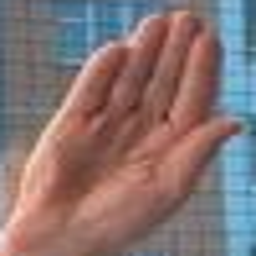

In [8]:
cropped_image = img.crop(shape)
resized_img = cropped_image.resize((256,256))
resized_img

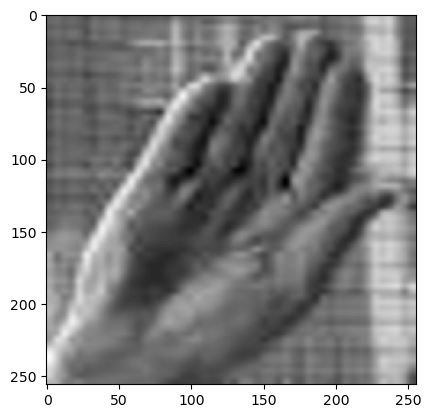

In [11]:
gray = cv2.cvtColor(np.array(resized_img), cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap = 'gray')

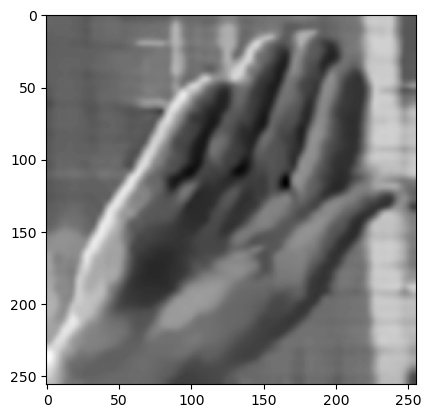

In [12]:
denoise_img = cv2.fastNlMeansDenoising(gray,None,10,7,21,)
plt.imshow(denoise_img,cmap = 'gray')

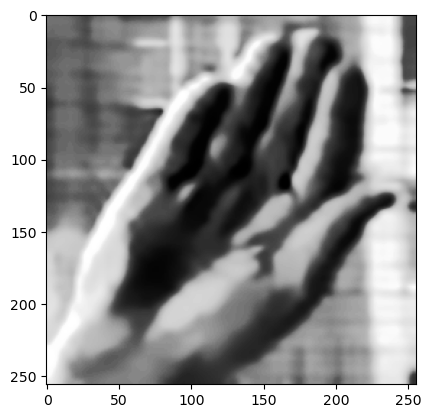

In [13]:
equalized_image = cv2.equalizeHist(denoise_img)
plt.imshow(equalized_image,cmap = 'gray')

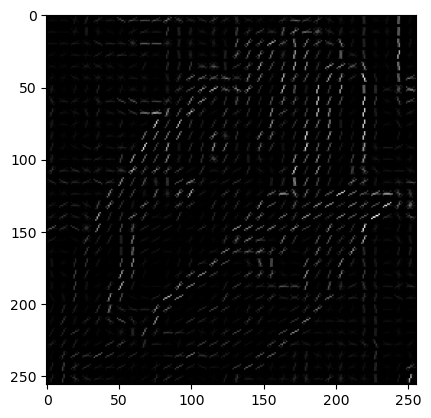

In [18]:
im_hog = hog(equalized_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),visualize = True)
plt.imshow(im_hog[1], cmap = 'gray')

## Load dataset

In [19]:
import os
all_label = os.listdir('/kaggle/input/hagrid-sample-500k-384p/hagrid-sample-500k-384p/hagrid_500k')
dataset_path = '/kaggle/input/hagrid-sample-500k-384p/hagrid-sample-500k-384p/hagrid_500k'


list_labels = ['train_val_stop', 'train_val_ok', 'train_val_mute', 'train_val_like', \
               'train_val_dislike', 'train_val_palm', 'train_val_two_up', 'train_val_peace']
list_labels_nogesture = [label for label in all_label if label not in list_labels]
list_labels_nogesture

['train_val_call',
 'train_val_three',
 'train_val_two_up_inverted',
 'train_val_four',
 'train_val_three2',
 'train_val_rock',
 'train_val_fist',
 'train_val_one',
 'train_val_peace_inverted',
 'train_val_stop_inverted']

In [20]:
def convert_label(label):
    return '_'.join(label.split("_")[2:])
convert_label('train_val_two_up')

'two_up'

In [24]:
images = []
labels = []
no_gesture_img = []
no_gesture_label = []
for label in list_labels:
    print(label, end=' ')
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        
        for image_name in tqdm(os.listdir(label_path)[:2000]):
            image_path = os.path.join(label_path, image_name)
            if image_path.endswith('.jpg'):
                image_name = image_name.split('.')[0]
                img = PIL.Image.open(image_path).convert('RGB')

                width, height = img.size
                bboxes = get_hand_bounding_box(image_name, convert_label(label), annotation_df)
                x,y,w,h = bboxes[0]
                x *= width
                y *= height
                w *= width
                h *= height
                shape = (x, y, x+w, y+h)

                cropped_image = img.crop(shape)
                resized_img = cropped_image.resize((64,64))     
                images.append(np.array(resized_img))
                labels.append(label)
                if len(bboxes) > 1: 
                    x,y,w,h = bboxes[1]
                    x *= width
                    y *= height
                    w *= width
                    h *= height
                    shape = (x, y, x+w, y+h)

                    cropped_image = img.crop(shape)
                    resized_img = cropped_image.resize((64,64)) 
                    no_gesture_img.append(np.array(resized_img))
                    no_gesture_label.append('No_Gesture')
for label in list_labels_nogesture:
    print(label, end=' ')
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        
        for image_name in tqdm(os.listdir(label_path)[:200]):
            image_path = os.path.join(label_path, image_name)
            if image_path.endswith('.jpg'):
                image_name = image_name.split('.')[0]
                img = PIL.Image.open(image_path).convert('RGB')

                width, height = img.size
                bboxes = get_hand_bounding_box(image_name, convert_label(label), annotation_df)
                x,y,w,h = bboxes[0]
                x *= width
                y *= height
                w *= width
                h *= height
                shape = (x, y, x+w, y+h)

                cropped_image = img.crop(shape)
                resized_img = cropped_image.resize((64,64))     
                no_gesture_img.append(np.array(resized_img))
                no_gesture_label.append('No_Gesture')
                if len(bboxes) > 1: 
                    x,y,w,h = bboxes[1]
                    x *= width
                    y *= height
                    w *= width
                    h *= height
                    shape = (x, y, x+w, y+h)

                    cropped_image = img.crop(shape)
                    resized_img = cropped_image.resize((64,64)) 
                    no_gesture_img.append(np.array(resized_img))
                    no_gesture_label.append('No_Gesture')

images = np.array(images)
labels = np.array(labels)
no_gesture_img = np.array(no_gesture_img)
no_gesture_label = np.array(no_gesture_label)

train_val_stop 

100%|██████████| 2000/2000 [00:15<00:00, 129.72it/s]


train_val_ok 

100%|██████████| 2000/2000 [00:14<00:00, 141.72it/s]


train_val_mute 

100%|██████████| 2000/2000 [00:14<00:00, 142.77it/s]


train_val_like 

100%|██████████| 2000/2000 [00:13<00:00, 150.16it/s]


train_val_dislike 

100%|██████████| 2000/2000 [00:13<00:00, 145.71it/s]


train_val_palm 

100%|██████████| 2000/2000 [00:13<00:00, 148.31it/s]


train_val_two_up 

100%|██████████| 2000/2000 [00:13<00:00, 143.92it/s]


train_val_peace 

100%|██████████| 2000/2000 [00:13<00:00, 144.31it/s]


train_val_call 

100%|██████████| 200/200 [00:00<00:00, 434.24it/s]


train_val_three 

100%|██████████| 200/200 [00:00<00:00, 497.08it/s]


train_val_two_up_inverted 

100%|██████████| 200/200 [00:00<00:00, 478.62it/s]


train_val_four 

100%|██████████| 200/200 [00:00<00:00, 486.15it/s]


train_val_three2 

100%|██████████| 200/200 [00:00<00:00, 475.09it/s]


train_val_rock 

100%|██████████| 200/200 [00:00<00:00, 464.46it/s]


train_val_fist 

100%|██████████| 200/200 [00:00<00:00, 501.63it/s]


train_val_one 

100%|██████████| 200/200 [00:00<00:00, 470.62it/s]


train_val_peace_inverted 

100%|██████████| 200/200 [00:00<00:00, 481.13it/s]


train_val_stop_inverted 

100%|██████████| 200/200 [00:00<00:00, 484.62it/s]


In [25]:
images = np.concatenate((images, no_gesture_img))
labels = np.concatenate((labels, no_gesture_label))

## Extract HOG features

In [26]:
from multiprocessing import Pool

def compute_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoise_img = cv2.fastNlMeansDenoising(gray,None,10,7,21,)
    equalized_image = cv2.equalizeHist(denoise_img)
    #blurred_image = cv2.GaussianBlur(equalized_image, (0, 0), 3)  # Apply Gaussian blurring to reduce noise
    #sharpened_image = cv2.addWeighted(equalized_image, 1.5, blurred_image, -0.5, 0)  # Perform unsharp masking
    #smoothed = cv2.medianBlur(equalized_image,1)

    hog_features = hog(equalized_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    return hog_features

# Define the number of processes to use
num_processes = 4  # Adjust the number of processes as per your system's capabilities

# Create a multiprocessing Pool
pool = Pool(num_processes)

# Compute HOG features in parallel
hog_features = list(tqdm(pool.imap(compute_hog, images), total=len(images)))

# Close the multiprocessing Pool
pool.close()
pool.join()


100%|██████████| 22097/22097 [03:35<00:00, 102.74it/s]


## Get train and test data

We will have two test data: One from HaGRID and one from our self collected dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

In [28]:
!pip install -q gdown

In [29]:
!gdown --id 1Y_amj2wGGW7-pLi-JgIznvNAN6mb2jQQ

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Y_amj2wGGW7-pLi-JgIznvNAN6mb2jQQ
From (redirected): https://drive.google.com/uc?id=1Y_amj2wGGW7-pLi-JgIznvNAN6mb2jQQ&confirm=t&uuid=b6e0e5c6-6b1f-4ddc-a53e-0773dea73cbc
To: /kaggle/working/crop_img.rar
100%|████████████████████████████████████████| 607M/607M [00:10<00:00, 55.2MB/s]


In [30]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 28 not upgraded.
Need to get 145 kB of archives.
After this operation, 339 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 unrar amd64 1:6.1.5-1 [145 kB]
Fetched 145 kB in 0s (380 kB/s)
Selecting previously unselected package unrar.
(Reading database ... 115376 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a6.1.5-1_amd64.deb ...
Unpacking unrar (1:6.1.5-1) ...
Setting up unrar (1:6.1.5-1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/unrar.1.gz because associated file /usr/share/man/man1/unrar-nonfree.1.gz (of link group unrar) doesn't exist
Processing triggers for man-db (2.10.2-1) ...

In [ ]:
!unrar x /kaggle/working/crop_img.rar

In [32]:
test_img = []
test_label = []
for label in os.listdir('crop_img'):
    print(label, end=' ')
    label_path = os.path.join('/kaggle/working/crop_img', label)
    if os.path.isdir(label_path):
        
        for image_name in tqdm(os.listdir(label_path)):
            image_path = os.path.join(label_path, image_name)
            if image_path.endswith('.png'):
                image_name = image_name.split('.')[0]
                img = PIL.Image.open(image_path).convert('RGB')

                width, height = img.size
                
                resized_img = img.resize((64,64))     
                test_img.append(np.array(resized_img))
                if label == 'no_gesture':
                    label = 'No_Gesture'
                test_label.append(label)
test_img = np.array(test_img)

stop 

100%|██████████| 100/100 [00:02<00:00, 33.60it/s]


dislike 

100%|██████████| 91/91 [00:02<00:00, 44.25it/s]


palm 

100%|██████████| 99/99 [00:04<00:00, 21.93it/s]


no_gesture 

100%|██████████| 72/72 [00:01<00:00, 50.27it/s]


like 

100%|██████████| 108/108 [00:01<00:00, 55.64it/s]


mute 

100%|██████████| 85/85 [00:01<00:00, 44.99it/s]


two_up 

100%|██████████| 97/97 [00:02<00:00, 40.65it/s]


ok 

100%|██████████| 93/93 [00:02<00:00, 32.21it/s]


peace 

100%|██████████| 102/102 [00:02<00:00, 40.39it/s]


In [33]:
num_processes = 4  # Adjust the number of processes as per your system's capabilities

# Create a multiprocessing Pool
pool = Pool(num_processes)

# Compute HOG features in parallel
hog_features_test = list(tqdm(pool.imap(compute_hog, test_img), total=len(test_img)))

# Close the multiprocessing Pool
pool.close()
pool.join()


100%|██████████| 847/847 [00:08<00:00, 103.49it/s]


In [34]:
for i in range (len(test_label)):
    if test_label[i] != 'No_Gesture':
        test_label[i] = 'train_val_' + test_label[i]

In [35]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the list
encoded_y = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(test_label)
encoded_y_HaGRID = label_encoder.transform(y_test)

## Modelling

### Gradient Boosting

In [36]:
import xgboost
xgb_model = xgboost.XGBClassifier(n_estimators=1000, 
                        max_depth=5, 
                        learning_rate=0.1, 
                        subsample=0.7,
                        colsample_bytree=0.8, 
                        colsample_bylevel=0.8,
                        tree_method= 'gpu_hist',
                        random_state=42, seed=42)
xgb_model.fit(X_train, encoded_y)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Linear SVM

In [37]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(dual=True, random_state=0, tol=1e-5)
svm_model.fit(X_train, encoded_y)

LinearSVC(random_state=0, tol=1e-05)

## Analyze results

In [38]:
y_pred_svm = svm_model.predict(hog_features_test)
y_pred_xgb = xgb_model.predict(hog_features_test)

In [39]:
y_pred_svm_hagrid = svm_model.predict(X_test)
y_pred_xgb_hagrid = xgb_model.predict(X_test)


In [40]:
print("Accuracy of xgb on HaGRID test set:", accuracy_score(encoded_y_HaGRID, y_pred_xgb_hagrid))
print("Accuracy of svm on HaGRID test set:", accuracy_score(encoded_y_HaGRID, y_pred_svm_hagrid))


Accuracy of xgb on HaGRID test set: 0.930316742081448
Accuracy of svm on HaGRID test set: 0.8760180995475113


In [41]:
print("Accuracy of xgb on our test set:", accuracy_score(encoded_y_test, y_pred_xgb))
print("Accuracy of svm on our test set:", accuracy_score(encoded_y_test, y_pred_svm))


Accuracy of xgb on our test set: 0.731995277449823
Accuracy of svm on our test set: 0.6599763872491146


In [ ]:
xgb_model.save_model("xgb_model.json")

In [42]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(encoded_y_test, y_pred_xgb)


In [43]:
from sklearn.metrics import classification_report
classification_report(encoded_y_test, y_pred_xgb, target_names=['no_gesture','dislike','like','mute','ok','palm','peace','stop','two_up'])

'              precision    recall  f1-score   support\n\n  no_gesture       0.28      0.82      0.42        72\n     dislike       0.93      0.85      0.89        91\n        like       0.85      0.87      0.86       108\n        mute       0.86      0.81      0.84        85\n          ok       0.77      0.57      0.65        93\n        palm       0.97      0.77      0.86        99\n       peace       0.87      0.53      0.66       102\n        stop       0.95      0.77      0.85       100\n      two_up       0.85      0.63      0.72        97\n\n    accuracy                           0.73       847\n   macro avg       0.81      0.73      0.75       847\nweighted avg       0.83      0.73      0.76       847\n'

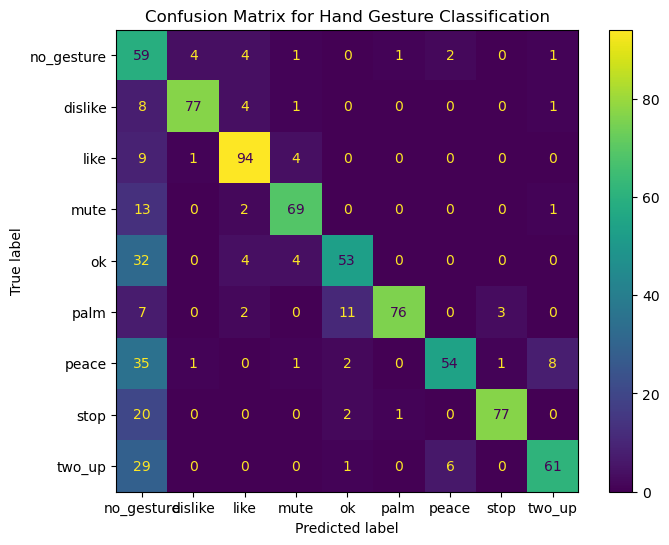

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=['no_gesture','dislike','like','mute','ok','palm','peace','stop','two_up'])
ax.set(title='Confusion Matrix for Hand Gesture Classification')
display.plot(ax=ax);


## Second method: Keypoint extractor

Currently, this method is not good enough so we don't put in our report. We will try to improve it in the future works

In [ ]:
def getKeypoint(image_array, visualize = False):
    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    denoise_img = cv2.fastNlMeansDenoising(gray,None,10,7,21,)
    equalized_image = cv2.equalizeHist(denoise_img)
    smoothed = cv2.medianBlur(equalized_image,1)
    edges = cv2.Canny(smoothed,66,66)
    #kernel = np.ones((2, 2), np.uint8)
    #img2 = cv2.morphologyEx(edges,cv2.MORPH_GRADIENT,kernel)
    sift = cv2.SIFT_create(200)
    keypoints, descriptors = sift.detectAndCompute(edges, None)

    if visualize:
        output_image = cv2.drawKeypoints(edges, keypoints, None)
        plt.imshow(output_image)
    else:
        return descriptors

In [ ]:
from multiprocessing import Pool
num_processes = 4  # Adjust the number of processes as per your system's capabilities

# Create a multiprocessing Pool
pool = Pool(num_processes)

# Compute HOG features in parallel
sift_descriptors = list(tqdm(pool.imap(getKeypoint, images), total=len(images)))

# Close the multiprocessing Pool
pool.close()
pool.join()


In [ ]:
from sklearn.cluster import MiniBatchKMeans
def cluster_features(train_data, all_data, cluster_model):
    n_clusters = cluster_model.n_clusters
    training_descs = train_data
    all_train_descriptors = [desc for desc_list in training_descs for desc in desc_list]
    all_train_descriptors = np.array(all_train_descriptors)


    print ('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print ('Using clustering model %s...' % repr(cluster_model))
    print ('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    print ('done clustering. Using clustering model to generate BoW histograms for each image.')

    # compute set of cluster-reduced words for each image
    img_clustered_words = [cluster_model.predict(raw_words) for raw_words in all_data]

    # finally make a histogram of clustered word counts for each image. These are the final features.
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])

    X = img_bow_hist
    print ('done generating BoW histograms.')

    return X, cluster_model

In [ ]:
labels = np.array(labels)
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Transform the labels into encoded integers
encoded_labels = label_encoder.transform(labels)


In [ ]:
def perform_data_split(X, y, training_idxs, test_idxs):
    X_train = X[training_idxs]
    X_test = X[test_idxs]

    y_train = y[training_idxs]
    y_test = y[test_idxs]

    return X_train, X_test, y_train, y_test

In [ ]:
sift_descriptors = np.array(sift_descriptors)
indices = np.arange(len(sift_descriptors))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,idx_train, idx_test = train_test_split(sift_descriptors, encoded_labels,indices, test_size=0.2, random_state=42)

X, cluster_model = cluster_features(X_train,sift_descriptors, MiniBatchKMeans(n_clusters=50))
X_train, X_test, y_train, y_test = perform_data_split(X, encoded_labels, idx_train, idx_test)

In [ ]:
idx_train


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sm
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Accuracy of RF:", accuracy_score(y_test, y_pred))

In [ ]:
getKeypoint(images[0],visualize=True)

In [ ]:
denoise_img = cv2.fastNlMeansDenoising(gray,None,10,7,21,)
plt.imshow(denoise_img,cmap = 'gray')

In [ ]:
equalized_image = cv2.equalizeHist(denoise_img)
plt.imshow(equalized_image,cmap = 'gray')

In [ ]:
blurred_image = cv2.GaussianBlur(equalized_image, (0, 0), 3)  # Apply Gaussian blurring to reduce noise
sharpened_image = cv2.addWeighted(equalized_image, 1.5, blurred_image, -0.5,0)  # Perform unsharp masking
plt.imshow(sharpened_image,cmap = 'gray')

In [ ]:

im_hog = hog(sharpened_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),visualize = True)
plt.imshow(im_hog[1])

In [ ]:
smoothed = cv2.medianBlur(equalized_image,1)
plt.imshow(smoothed,cmap = 'gray')

In [ ]:
edges = cv2.Canny(denoise_img,66,66)
plt.imshow(edges)

In [ ]:
kernel = np.ones((2, 2), np.uint8)

img2 = cv2.morphologyEx(edges,cv2.MORPH_GRADIENT,kernel)
plt.imshow(img2)

In [ ]:
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img2, None)
output_image = cv2.drawKeypoints(img2, keypoints, None)
plt.imshow(output_image)